@author: Boda Ye
This python file used to label conn log file by using honeypot logfile.

        def ip_list:        create honeypot ip_time dictionary
                            like, { ip1: {time1,time2}, ip2:{time5, time 6, time7}}


    class label: utilize the ip_time dicitonary to label the conn log file

        def subset_conn:    This function is used to subset the honeypot file, pick out rows with 'malicious ip'
                            (ip caught in honeypot)

        def preprocess_ip:  This function is used to convert the ip_time dicitonary to ip_start_end dictionary 
                            ip1: {10,15,30} window=10  => ip1:{0-20, 5-25, 20-40} => ip1:{ 0-20}
                            The unit for window is sec

        def merge:          Finally label conn log file
    

In [1]:
import numpy as np
import pandas as pd
import re
import time
from datetime import datetime

In [2]:

#create honeypot ip_time dictionary
#like, { ip1: {time1,time2}, ip2:{time5, time 6, time7}}
#input honeypotfile should be csv
def ip_list(honeypot):
    start_time = time.time()
    hp=pd.read_csv(honeypot)
    #read in honeypot file,and transfer timestamp to unix format
    hp.timestamp = [time.mktime(datetime.strptime(x[:18], '%Y-%m-%d %H:%M:%S').timetuple())\
            for x in hp.timestamp]

    #create honeypot ip_time dictionary
    #like, { ip1: {time1,time2}, ip2:{time5, time 6, time7}}
    df=hp.iloc[:,[1,4]]
    ip_time={}
    for index,row in df.iterrows():
        ts,sip=int(row[0]),row[1].strip()
        if sip=='0':continue
        if sip not in ip_time.keys():
            ip_time[sip]={ts}
        else:
            ip_time[sip].add(ts)

    print("--- %s seconds ---" % (time.time() - start_time))
    #return a dictionary
    return ip_time

In [3]:
ip_time=ip_list('/scratch/by8jj/honeypot2_1.csv')

--- 314.21079421043396 seconds ---


In [4]:
class label(object):
    
    
    def __init__(self,conn):
        self.conn=conn
        
    
    #This function is used to subset the honeypot file
    def subset_conn(self,ip_time):
        malicious_ip=[x for x in ip_time.keys()]
        
        #read in the file
        f = open(self.conn, 'r')

        #initialize output
        out = open('subset_conn.temp', 'w')
        
        
       
        counter=1
        line=f.readline().strip()
        #subset the file
        while line:
            counter+=1
            lsplit = line.split('\t')
            try:
                ts, uid, sip, = lsplit[0][:10],lsplit[1], lsplit[2]
                line = '\t'.join([ts,uid,sip])+'\n'
                out.write(line)
            except:
                if 'open' in line: print(line)
            line = f.readline().strip() 
        
        print(counter)
        f.close()
        out.close()
        
        
    
    #a mini function to check whether there's overlap between 2 duration
    def overlap(self,a,b):
        if a[1]<b[0]:return True
        return False
    
    
    #This function is used to convert the ip_time dicitonary to ip_start_end dictionary 
    #ip1: {10,15,30} window=10  => ip1:{0-20, 5-25, 20-40} => ip1:{ 0-20}
    #The unit for window is sec
    def preprocess_ip(self,ip_time,ts_window=13,window=43200):
        
        #To simplify problem, I assume  within one minute are the same
        #choose 13 here is because of mean duration is 13
        
        out={}
        for key,value in ip_time.items():

            #reduce connection happened within 1 minute
            time=[int(x) for x in value]
            temp=[time[0]]
            for j in range(len(time)-1):
                if time[j+1]-time[j]>ts_window: temp.append(time[j+1])           


            #create the start_end for each item in temp
            temp=[(x,x+window) for x in temp]


            #merge start_end
            merged_start_end=[temp[0]]
            for j in range(1,len(temp)):
                current_start_end=merged_start_end.pop()
                if self.overlap(current_start_end,temp[j]):
                    merged_start_end.append((current_start_end[0],temp[j][1]))
                else:
                    merged_start_end.append(current_start_end)
                    merged_start_end.append(temp[j])
            out[key]=merged_start_end
    
        #return a dictionary 
        return out
        
        

    def merge(self,ip_time,outfile='labeled.log'):
        
        out=open(outfile,'w')
        f=open('/scratch/by8jj/window_function/subset_conn.temp','r')
        
        line=f.readline().strip()
        while line:
            temp=line.split('\t')
            try:
                ts,uid,ip=temp[0],temp[1],temp[2]


                #check if time is within the range
                if ip not in ip_time.keys():
                    line=f.readline().strip()
                    continue


                for j in ip_time[ip]:
                    if int(ts)>=int(j[0]) and int(ts)<=int(j[1]):
                        out.write(uid+'\n')
                        break
            except:
                print(line)

            line=f.readline().strip()
        out.close()
        f.close()
        

In [5]:
p=label('/scratch/by8jj/conn_log_sample/merged_tcp.log')

In [6]:
start_time = time.time()
p.subset_conn(ip_time)
processed_ip_time=p.preprocess_ip(ip_time)
p.merge(processed_ip_time)
print("--- %s seconds ---" % (time.time() - start_time))

#open	2018-08-19-20-00-00
#open	2018-08-19-21-00-00
#open	2018-08-19-22-00-00
#open	2018-08-19-23-00-00
27880564
--- 73.43284010887146 seconds ---


In [7]:
#count the number of malicious id with different windows
def count(file='/scratch/by8jj/window_function/labeled.log'):
    f=open(file,'r')
    line=f.readline().strip()
    counter=0
    while line:
        counter+=1
        line=f.readline().strip()
    f.close()
    return counter

In [8]:
#use grid search to check the window
mali_list=[]
for i in range(10800,216000,3600):
    start_time = time.time()
    processed_ip_time=p.preprocess_ip(ip_time, window=i)
    p.merge(processed_ip_time)
    temp=count()
    mali_list.append(temp)
    print(temp)
    print("--- %s seconds ---" %(time.time() - start_time))

354974
--- 26.497057914733887 seconds ---
358040
--- 26.74193572998047 seconds ---
366106
--- 26.644392251968384 seconds ---
373963
--- 26.631086826324463 seconds ---
381960
--- 26.27321171760559 seconds ---
387341
--- 26.65159010887146 seconds ---
387725
--- 26.199263095855713 seconds ---
388049
--- 26.23938775062561 seconds ---
389359
--- 26.098615884780884 seconds ---
435498
--- 26.203414916992188 seconds ---
497671
--- 26.72201442718506 seconds ---
557233
--- 26.37146759033203 seconds ---
589581
--- 26.28674006462097 seconds ---
590768
--- 26.367616415023804 seconds ---
596927
--- 26.312296628952026 seconds ---
597690
--- 26.233898639678955 seconds ---
604491
--- 26.35321307182312 seconds ---
613259
--- 26.39926028251648 seconds ---
622039
--- 26.014887809753418 seconds ---
630822
--- 26.386980772018433 seconds ---
635369
--- 26.584534406661987 seconds ---
639139
--- 26.281177043914795 seconds ---
642975
--- 26.396009922027588 seconds ---
646814
--- 26.309019565582275 seconds ---
6

In [9]:
#write out mali_list to visulization by using excel
df_out=pd.DataFrame({'mal':mali_list})
df_out.to_csv('mali_per_hour.csv')

(3, 63)

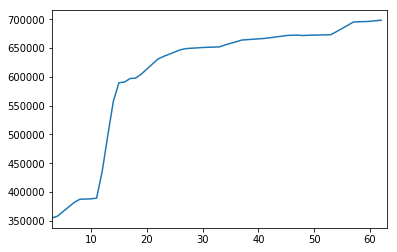

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(3,63),mali_list)
plt.xlim(3,63)